In [40]:
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np
from tqdm.notebook import tqdm
import torch.utils.data as data
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import pandas as pd

from loader import load_data
from model import MRNet

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn import svm
import scikitplot as skplt
from ipywidgets import interact, widgets

## Function for getting predictions

In [2]:
os.listdir('models/alexnet-old/')

['model_abnormal_coronal_val_auc_0.8274_train_auc_0.9746_epoch_11.pth',
 'model_acl_coronal_val_auc_0.9097_train_auc_0.9846_epoch_21.pth',
 'model_meniscus_sagittal_val_auc_0.7851_train_auc_0.8461_epoch_22.pth',
 'model_acl_axial_val_auc_0.9369_train_auc_0.9992_epoch_22.pth',
 'model_meniscus_coronal_val_auc_0.8179_train_auc_0.9563_epoch_10.pth',
 'model_abnormal_sagittal_val_auc_0.9368_train_auc_0.9862_epoch_14.pth',
 'model_meniscus_axial_val_auc_0.8156_train_auc_0.9853_epoch_19.pth',
 'model_abnormal_axial_val_auc_0.9562_train_auc_0.9848_epoch_19.pth',
 'model_acl_sagittal_val_auc_0.9644_train_auc_0.9987_epoch_35.pth']

In [3]:
def extract_predictions(task, plane, use_gpu= True, train=True):
    assert task in ['acl', 'meniscus', 'abnormal']
    assert plane in ['axial', 'coronal', 'sagittal']

    models = os.listdir('models/alexnet-old/')

    model_name = list(
        filter(lambda name: task in name and plane in name, models))[0]
    model_path = f'models/alexnet-old/{model_name}'
    print(model_name)

    mrnet = MRNet(backbone='alexnet')
    mrnet.load_state_dict(torch.load(model_path))
    _ = mrnet.eval()
    mrnet.cuda()
    
    train_loader, valid_loader = load_data(task=task, plane=plane)
    
    predictions = []
    labels = []
    count = 0
    if(train):
        with torch.no_grad():
            for image, label in tqdm(train_loader):
                logit = mrnet(image.cuda())
                prediction = torch.sigmoid(logit)
                predictions.append(prediction.cpu().numpy())
                labels.append(label.cpu().numpy())
    else:
        with torch.no_grad():
            for image, label in tqdm(valid_loader):
                logit = mrnet(image.cuda())
                prediction = torch.sigmoid(logit)
                predictions.append(prediction.cpu().numpy())
                labels.append(label.cpu().numpy())
    return predictions, labels

In [4]:
def GetPredictions(task, train):
    results = {}
    for plane in ['axial', 'coronal', 'sagittal']:
        print(plane)
        predictions, labels = extract_predictions(task, plane, use_gpu=False, train=train)
        results['labels'] = labels
        results[plane] = predictions
    return predictions, results

## Function for building dataset for Logistic Regression

In [5]:
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix

def GetAUC(task, train):
    predictions, results = GetPredictions(task=task, train=train)
    X = np.zeros((len(predictions), 3))
    X[:, 0] = [z[0][0] for z in results['axial']]
    X[:, 1] = [z[0][0] for z in results['coronal']]
    X[:, 2] = [z[0][0] for z in results['sagittal']]
    y = np.array([label[0][0] for label in results['labels']])
    return X,y
def logRegClassifier(parameters, c_parameters,X_train,y_train,X_dev,y_dev):
    """
    Function to implement Logistic Regression classifier
    and returns the best classifier based on different
    Solvers, penalties and C paramenters. 
    """
    print("\n      ***************Logistic Regression Classifier*****************      ")
    best_AUC = 0
    best_clf = None
    for paramenter in parameters:
        for c_parameter in c_parameters:
            clf=LogisticRegression(
                solver=paramenter["solver"],
                penalty=paramenter["penalty"],
                C=c_parameter,
                max_iter=10000
            )
            print('Logistic Regression with hyperparameter as'+
                  f'(solver={paramenter["solver"]}, penalty={paramenter["penalty"]}, C={c_parameter})')
            clf.fit(X_train, y_train)            
            pred_dev = clf.predict_proba(X_dev)[:, 1]
            AUC = metrics.roc_auc_score(y_dev, pred_dev)
            print("AUC:", AUC)
            print("********************************************************************************")
            if (AUC >= best_AUC):
                best_clf = clf
                best_AUC = AUC
    print("\n                                END OF TRAINING                                 ")
    print("\n********************************************************************************")            
    print("Best logistic regression classifier is \n {} \n with validation F1-score {}".format(best_clf, best_AUC))
    print("********************************************************************************")
    return best_clf

def svcClassifier(gammas,kernals,c_parameters,X_train,y_train,X_dev,y_dev):
    """
    Function to implement Logistic Regression classifier
    and returns the best classifier based on different
    Solvers, penalties and C paramenters. 
    """
    print("\n      ***************SVM Classifier*****************      ")
    best_AUC = 0
    best_clf = None
    for kernel in kernals:
        for gamma in gammas:
            for c_parameter in c_parameters:
                    clf=SVC(
                        kernel=kernel,
                        gamma=gamma,
                        C=c_parameter,
                        max_iter=10000,
                        probability = True
                    )
                    print('Logistic Regression with hyperparameter as'+
                          f'(kernel={kernel}, gamma={gamma}, C={c_parameter})')
                    clf.fit(X_train, y_train)            
                    pred_dev = clf.predict_proba(X_dev)[:, 1]
                    AUC = metrics.roc_auc_score(y_dev, pred_dev)
                    print("AUC:", AUC)
                    print("********************************************************************************")
                    if (AUC >= best_AUC):
                        best_clf = clf
                        best_AUC = AUC
    print("\n                                END OF TRAINING                                 ")
    print("\n********************************************************************************")            
    print("Best SVM classifier is \n {} \n with validation F1-score {}".format(best_clf, best_AUC))
    print("********************************************************************************")
    return best_clf

def GetPredictionsFromThreshold(preds,threshold):
    ret = list()
    for pred in preds:
        if pred>threshold:
            ret.append(1)
        else:
            ret.append(0)
    return ret


def GetBestThreshold(model,X_val,y_val):
    # pr curve for logistic regression model
    preds = model.predict_proba(X_val)[:,1]
    precision, recall, thresholds = metrics.precision_recall_curve(y_val,preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

    # plot the roc curve for the model
    pyplot.plot(recall, precision, marker='.', label='SVM')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()
    print("******************* Confusion Matrix ***********************")
    threshold_preds = GetPredictionsFromThreshold(preds=preds,threshold=thresholds[ix])
    print(confusion_matrix(y_val,threshold_preds))
    return (thresholds[ix], fscore[ix], threshold_preds)

## Generating results from all MRNet 

In [6]:
X_acl,y_acl, = GetAUC('acl', train=True)
X_acl_val,y_acl_val = GetAUC('acl', train=False)

axial
model_acl_axial_val_auc_0.9369_train_auc_0.9992_epoch_22.pth



coronal
model_acl_coronal_val_auc_0.9097_train_auc_0.9846_epoch_21.pth



sagittal
model_acl_sagittal_val_auc_0.9644_train_auc_0.9987_epoch_35.pth



axial
model_acl_axial_val_auc_0.9369_train_auc_0.9992_epoch_22.pth



coronal
model_acl_coronal_val_auc_0.9097_train_auc_0.9846_epoch_21.pth



sagittal
model_acl_sagittal_val_auc_0.9644_train_auc_0.9987_epoch_35.pth


In [7]:
X_abnormal,y_abnormal = GetAUC('abnormal', train=True)
X_abnormal_val,y_abnormal_val = GetAUC('abnormal', train=False)

axial
model_abnormal_axial_val_auc_0.9562_train_auc_0.9848_epoch_19.pth



coronal
model_abnormal_coronal_val_auc_0.8274_train_auc_0.9746_epoch_11.pth



sagittal
model_abnormal_sagittal_val_auc_0.9368_train_auc_0.9862_epoch_14.pth



axial
model_abnormal_axial_val_auc_0.9562_train_auc_0.9848_epoch_19.pth



coronal
model_abnormal_coronal_val_auc_0.8274_train_auc_0.9746_epoch_11.pth



sagittal
model_abnormal_sagittal_val_auc_0.9368_train_auc_0.9862_epoch_14.pth


In [8]:
X_meniscus,y_meniscus = GetAUC('meniscus', train=True)
X_meniscus_val,y_meniscus_val = GetAUC('meniscus', train=False)

axial
model_meniscus_axial_val_auc_0.8156_train_auc_0.9853_epoch_19.pth



coronal
model_meniscus_coronal_val_auc_0.8179_train_auc_0.9563_epoch_10.pth



sagittal
model_meniscus_sagittal_val_auc_0.7851_train_auc_0.8461_epoch_22.pth



axial
model_meniscus_axial_val_auc_0.8156_train_auc_0.9853_epoch_19.pth



coronal
model_meniscus_coronal_val_auc_0.8179_train_auc_0.9563_epoch_10.pth



sagittal
model_meniscus_sagittal_val_auc_0.7851_train_auc_0.8461_epoch_22.pth


In [146]:
from sklearn.svm import SVC
gammas = [0.1, 1, 10, 100]
kernels = ['linear', 'rbf', 'poly']
c_parameters = np.logspace(-4,4,100)
degrees = [0, 1, 2, 3, 4, 5, 6]

# abnormalSVM = svcClassifier(gammas,kernels,c_parameters,X_abnormal,y_abnormal,X_abnormal_val,y_abnormal_val)
# aclSVM = svcClassifier(gammas,kernels,c_parameters,X_acl,y_acl,X_acl_val,y_acl_val)
meniscusSVM = svcClassifier(gammas,kernels,c_parameters,X_meniscus,y_meniscus,X_meniscus_val,y_meniscus_val)


      ***************SVM Classifier*****************      
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.0001)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.00012045035402587823)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.000145082877849594)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.0001747528400007683)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.00021049041445120198)
AUC: 0.7451923076923077
****************************************

AUC: 0.7461821266968326
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.24770763559917114)
AUC: 0.7444852941176471
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.298364724028334)
AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.3593813663804629)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.43287612810830617)
AUC: 0.7457579185520362
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=0.521400828799969)
AUC: 0.7468891402714

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7458993212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=54.62277217684348)
AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=65.79332246575683)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=79.24828983539186)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7467477375565611
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=95.45484566618347)
AUC: 0.7470305429864253
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=114.9756995397738)
AUC: 0.7449095022624435
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=138.48863713938746)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7478789592760181
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=166.81005372000593)
AUC: 0.7451923076923078
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=242.01282647943833)
AUC: 0.7480203619909503
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7451923076923077
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=351.11917342151344)
AUC: 0.7434954751131221
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7311934389140272
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=509.4138014816386)
AUC: 0.7112556561085973
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7651300904977376
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=739.072203352579)
AUC: 0.737839366515837
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6849547511312217
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=1072.2672220103254)
AUC: 0.6835407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=1555.6761439304755)
AUC: 0.18071266968325791
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7502828054298643
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22242647058823528
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3781108597285068
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5842760180995475
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.772341628959276
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.751131221719457
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7420814479638009
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1716628959276018
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=0.1, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.31165158371040724
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.0001)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.00012045035402587823)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.000145082877849594)
AUC: 0.7451923076923077
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.0001747528400007683)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.00021049041445120198)
AUC: 0.7446266968325792
****

AUC: 0.7444852941176471
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.298364724028334)
AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.3593813663804629)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.43287612810830617)
AUC: 0.7457579185520362
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.521400828799969)
AUC: 0.7468891402714932
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=0.6280291441834259)
AUC: 0.7470305429864253
*******

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7458993212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=65.79332246575683)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=79.24828983539186)
AUC: 0.7470305429864253
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7473133484162896
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=114.9756995397738)
AUC: 0.7449095022624435
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=138.48863713938746)
AUC: 0.7477375565610861
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7454751131221721
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=200.923300256505)
AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7483031674208146
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=291.5053062825182)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7436368778280543
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=422.9242874389508)
AUC: 0.7310520361990951
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7112556561085973
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=613.5907273413176)
AUC: 0.7649886877828054
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.737839366515837
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=890.2150854450392)
AUC: 0.6848133484162896
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6835407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=1291.5496650148852)
AUC: 0.7543834841628959
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18071266968325791
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=1873.8174228603868)
AUC: 0.7502828054298643
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.2220022624434389
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.37754524886877827
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=3274.5491628777318)
AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5828619909502263
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7716346153846154
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7512726244343891
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7420814479638009
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17138009049773753
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=1, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.31165158371040724
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.0001)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.00012045035402587823)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.000145082877849594)
AUC: 0.7451923076923077
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.0001747528400007683)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.00021049041445120198)
AUC: 0.7451923076923077

AUC: 0.7444852941176471
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.298364724028334)
AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.3593813663804629)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.43287612810830617)
AUC: 0.7457579185520362
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.521400828799969)
AUC: 0.7467477375565611
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=0.6280291441834259)
AUC: 0.7470305429864253
**

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=65.79332246575683)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=79.24828983539186)
AUC: 0.7467477375565611
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7468891402714932
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=114.9756995397738)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=138.48863713938746)
AUC: 0.7478789592760181
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=200.923300256505)
AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7477375565610861
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=291.5053062825182)
AUC: 0.7451923076923077
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7436368778280543
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=422.9242874389508)
AUC: 0.7310520361990951
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7112556561085973
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=613.5907273413176)
AUC: 0.7649886877828054
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.737839366515837
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=890.2150854450392)
AUC: 0.6849547511312217
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6835407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=1291.5496650148852)
AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18071266968325791
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=1873.8174228603868)
AUC: 0.7502828054298643
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22228506787330315
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.37754524886877827
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5838518099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.771210407239819
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7514140271493213
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7420814479638009
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17138009049773753
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=10, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.31165158371040724
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.0001)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.00012045035402587823)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.000145082877849594)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.0001747528400007683)
AUC: 0.7446266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.00021049041445120198)
AUC: 0.74519230769

AUC: 0.7444852941176471
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.298364724028334)
AUC: 0.7453337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.3593813663804629)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.43287612810830617)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.521400828799969)
AUC: 0.7467477375565611
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=0.6280291441834259)
AUC: 0.74703054298642

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=65.79332246575683)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=79.24828983539186)
AUC: 0.7467477375565611
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7470305429864253
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=114.9756995397738)
AUC: 0.7450509049773756
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=138.48863713938746)
AUC: 0.7478789592760181
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7454751131221721
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=200.923300256505)
AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7480203619909503
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=291.5053062825182)
AUC: 0.7456165158371042
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7434954751131221
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=422.9242874389508)
AUC: 0.7311934389140272
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7111142533936652
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=613.5907273413176)
AUC: 0.7649886877828054
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.737839366515837
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=890.2150854450392)
AUC: 0.6846719457013575
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6835407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7542420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18071266968325791
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=1873.8174228603868)
AUC: 0.7502828054298643
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22228506787330315
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3771210407239819
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5834276018099548
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7720588235294118
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7514140271493212
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7420814479638009
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17138009049773753
********************************************************************************
Logistic Regression with hyperparameter as(kernel=linear, gamma=100, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6883484162895929
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.0001)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.00012045035402587823)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.000145082877849594)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.0001747528400007683)
AUC: 0.7454751131221719
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.00021049041445120198)
AUC: 0.7454751131221719
**********

AUC: 0.7461821266968326
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.43287612810830617)
AUC: 0.7461821266968326
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.521400828799969)
AUC: 0.7444852941176471
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.6280291441834259)
AUC: 0.7456165158371041
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.7564633275546291)
AUC: 0.7447680995475113
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=0.9111627561154896)
AUC: 0.7461821266968326
***********

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7350113122171946
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=509.4138014816386)
AUC: 0.7350113122171946
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7344457013574661
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=739.072203352579)
AUC: 0.7341628959276019
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7327488687782806
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=1072.2672220103254)
AUC: 0.732183257918552
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7321832579185521
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=1555.6761439304755)
AUC: 0.7327488687782805
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7344457013574661
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=2257.0197196339213)
AUC: 0.7347285067873303
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7378393665158371
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7327488687782806
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7296380090497738
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7378393665158371
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6891968325791855
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5405825791855203
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.21111425339366519
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=0.1, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7276583710407241
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.0001)
AUC: 0.7273755656108597
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.00012045035402587823)
AUC: 0.7273755656108597
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.000145082877849594)
AUC: 0.7255373303167421
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.0001747528400007683)
AUC: 0.7256787330316742
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.00021049041445120198)
AUC: 0.7262443438914027
********************

AUC: 0.7398190045248869
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.298364724028334)
AUC: 0.7412330316742081
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.3593813663804629)
AUC: 0.7403846153846154
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.43287612810830617)
AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.521400828799969)
AUC: 0.7398190045248869
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=0.6280291441834259)
AUC: 0.7395361990950226
**********************

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7214366515837105
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=65.79332246575683)
AUC: 0.7205882352941176
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=79.24828983539186)
AUC: 0.719739819004525
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=95.45484566618347)
AUC: 0.7149321266968325
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=114.9756995397738)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7115384615384615
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=138.48863713938746)
AUC: 0.7109728506787331
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7106900452488688
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=200.923300256505)
AUC: 0.7061651583710408
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7027714932126697
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.71210407239819
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7027714932126696
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6993778280542986
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6954185520361991
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7214366515837105
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6894796380090498
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6303733031674208
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6993778280542986
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7180429864253395
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7434954751131222
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7344457013574661
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5725395927601811
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6544117647058824
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7036199095022625
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7245475113122173
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6326357466063348
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7074377828054298
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6300904977375565
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=1, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.48699095022624433
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.0001)
AUC: 0.6914592760180996
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.00012045035402587823)
AUC: 0.6914592760180996
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.000145082877849594)
AUC: 0.6914592760180996
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.0001747528400007683)
AUC: 0.6917420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.00021049041445120198)
AUC: 0.6891968325791856
**************

AUC: 0.7121040723981901
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.43287612810830617)
AUC: 0.7140837104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.521400828799969)
AUC: 0.7138009049773755
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.6280291441834259)
AUC: 0.7115384615384616
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.7564633275546291)
AUC: 0.7123868778280542
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=0.9111627561154896)
AUC: 0.7055995475113123
****************

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6631787330316742
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=25.950242113997373)
AUC: 0.6592194570135745
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=31.257158496882415)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6541289592760181
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=37.649358067924716)
AUC: 0.6561085972850679
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=45.34878508128591)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6552601809954751
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=54.62277217684348)
AUC: 0.6538461538461539
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=65.79332246575683)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6544117647058824
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=79.24828983539186)
AUC: 0.6549773755656109
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6566742081447964
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=114.9756995397738)
AUC: 0.6589366515837105
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=138.48863713938746)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6546945701357466
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6538461538461539
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6479072398190046
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6580882352941176
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6589366515837104
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6603506787330317
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6521493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6521493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6315045248868778
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6016685520361991
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5777714932126696
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.620475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.610576923076923
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5933257918552036
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6561085972850679
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5680147058823529
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5138574660633484
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6080316742081449
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6326357466063348
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.43453054298642535
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3823529411764706
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.43552036199095023
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5805995475113123
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=10, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5531674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.0001)
AUC: 0.7528280542986426
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.00012045035402587823)
AUC: 0.7528280542986426
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.000145082877849594)
AUC: 0.7528280542986426
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.0001747528400007683)
AUC: 0.7528280542986426
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.00021049041445120198)
AUC: 0.7528280542986426
**********

AUC: 0.7460407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.3593813663804629)
AUC: 0.7449095022624435
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.43287612810830617)
AUC: 0.7437782805429863
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.521400828799969)
AUC: 0.7384049773755657
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.6280291441834259)
AUC: 0.7333144796380091
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=0.7564633275546291)
AUC: 0.7313348416289592
***********

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6481900452488688
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6541289592760181
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6586538461538461
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6611990950226245
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6631787330316742
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6617647058823529
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6609162895927602
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6586538461538461
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6595022624434389
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6589366515837104
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6611990950226244
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6603506787330317
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=rbf, gamma=100, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6592194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.0001)
AUC: 0.8026018099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.00012045035402587823)
AUC: 0.8026018099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.000145082877849594)
AUC: 0.8026018099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.0001747528400007683)
AUC: 0.8026018099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.00021049041445120198)
AUC: 0.8026018099547512
*****

AUC: 0.7986425339366516
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.43287612810830617)
AUC: 0.7986425339366516
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.521400828799969)
AUC: 0.7986425339366516
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.6280291441834259)
AUC: 0.7986425339366516
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.7564633275546291)
AUC: 0.7986425339366516
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=0.9111627561154896)
AUC: 0.7986425339366516
******

AUC: 0.7375565610859728
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=2257.0197196339213)
AUC: 0.7361425339366515
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=2718.5882427329457)
AUC: 0.7352941176470589
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=3274.5491628777318)
AUC: 0.7355769230769231
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=3944.206059437664)
AUC: 0.7358597285067874
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=0.1, C=4750.810162102803)
AUC: 0.7355769230769231
********

AUC: 0.7468891402714932
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=0.14174741629268062)
AUC: 0.7460407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=0.1707352647470692)
AUC: 0.7457579185520362
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=0.20565123083486536)
AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=0.24770763559917114)
AUC: 0.7420814479638009
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=0.298364724028334)
AUC: 0.7409502262443439
***************

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7398190045248869
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=12.328467394420684)
AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=14.849682622544666)
AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=17.886495290574352)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7384049773755657
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=21.544346900318867)
AUC: 0.740101809954751
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=25.950242113997373)
AUC: 0.7398190045248869
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=31.257158496882415)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=37.649358067924716)
AUC: 0.748868778280543
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=45.34878508128591)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7395361990950227
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=54.62277217684348)
AUC: 0.746606334841629
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=65.79332246575683)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7350113122171946
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=79.24828983539186)
AUC: 0.7392533936651584
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7180429864253394
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=114.9756995397738)
AUC: 0.7358597285067874
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=138.48863713938746)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6688348416289592
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=166.81005372000593)
AUC: 0.7584841628959276
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7350113122171946
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7638574660633484
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7719174208144796
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3150452488687783
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5113122171945701
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.4533371040723982
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8031674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7661199095022624
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.806843891402715
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5709841628959277
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.42166289592760176
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8051470588235294
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17986425339366513
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.2027714932126697
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.73670814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19372171945701358
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16600678733031676
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.23076923076923075
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6609162895927603
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.807975113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17873303167420815
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=1, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8345588235294117
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.0001)
AUC: 0.7480203619909502
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.00012045035402587823)
AUC: 0.746606334841629
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.000145082877849594)
AUC: 0.7460407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.0001747528400007683)
AUC: 0.745475113122172
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.00021049041445120198)
AUC: 0.745475113122172
*************

/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.018307382802953697)
AUC: 0.7403846153846154
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.022051307399030457)
AUC: 0.7401018099547512
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.026560877829466867)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7398190045248869
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.03199267137797385)
AUC: 0.7313348416289593
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.03853528593710531)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7433540723981901
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.04641588833612782)
AUC: 0.7333144796380091
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.055908101825122285)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7347285067873304
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.06734150657750829)
AUC: 0.7525452488687783
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.08111308307896872)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7386877828054299
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.09770099572992257)
AUC: 0.7460407239819005
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.1176811952434999)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6979638009049773
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.14174741629268062)
AUC: 0.7398190045248868
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.1707352647470692)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6023755656108597
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.20565123083486536)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6747737556561086
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.24770763559917114)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.684106334841629
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.298364724028334)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19032805429864252
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.3593813663804629)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16374434389140274
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.43287612810830617)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7183257918552036
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.521400828799969)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7504242081447964
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.6280291441834259)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7664027149321267
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.7564633275546291)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.41600678733031676
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=0.9111627561154896)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5868212669683258
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1.0974987654930568)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6245757918552037
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1.3219411484660315)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6430995475113123
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1.592282793341094)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8119343891402715
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1.9179102616724888)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7649886877828055
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=2.310129700083163)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7637160633484162
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=2.782559402207126)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8365384615384615
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=3.351602650938848)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18467194570135745
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=4.037017258596558)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17180429864253394
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=4.862601580065354)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7873303167420814
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=5.857020818056673)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17505656108597284
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=7.054802310718645)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22369909502262442
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=8.497534359086455)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8229638009049774
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=10.235310218990268)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1828337104072398
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=12.328467394420684)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8255090497737556
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=14.849682622544666)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.27007918552036203
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=17.886495290574352)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1710972850678733
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=21.544346900318867)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22794117647058823
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=25.950242113997373)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.833710407239819
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=31.257158496882415)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1668552036199095
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=37.649358067924716)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16968325791855204
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=45.34878508128591)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7893099547511312
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=54.62277217684348)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5740950226244345
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=65.79332246575683)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.30345022624434387
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=79.24828983539186)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.27884615384615385
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16657239819004527
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=114.9756995397738)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5619343891402715
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=138.48863713938746)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.709841628959276
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1875
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17562217194570137
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8156108597285068
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7555147058823529
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8266402714932127
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.29751131221719457
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19739819004524886
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7918552036199096
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7836538461538463
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8030260180995475
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8195701357466063
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1971153846153846
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6809954751131222
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19400452488687783
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1722285067873303
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=2718.5882427329457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.20984162895927602
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.20475113122171948
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19315610859728505
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.752262443438914
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7395361990950227
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7890271493212669
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16572398190045246
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=10, C=10000.0)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16572398190045248
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0001)
AUC: 0.739960407239819
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.00012045035402587823)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7395361990950227
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.000145082877849594)
AUC: 0.6790158371040724
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0001747528400007683)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6224547511312217
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.00021049041445120198)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6343325791855203
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.00025353644939701115)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.704185520361991
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0003053855508833416)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.31815610859728505
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0003678379771828634)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7802601809954751
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0004430621457583882)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.46832579185520357
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0005336699231206312)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.20687217194570134
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0006428073117284319)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.567024886877828
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.000774263682681127)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7536764705882353
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0009326033468832199)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7432126696832579
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0011233240329780276)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.2536764705882353
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0013530477745798076)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8322963800904978
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0016297508346206436)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.17873303167420812
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0019630406500402726)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.20955882352941174
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.002364489412645407)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3532239819004525
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.002848035868435802)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16572398190045248
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.003430469286314919)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16713800904977377
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.0041320124001153384)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18552036199095023
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.004977023564332114)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8356900452488688
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.005994842503189409)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7842194570135747
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.007220809018385471)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.832579185520362
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.008697490026177835)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.167420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.010476157527896652)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.3481334841628959
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.012618568830660211)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1759049773755656
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.015199110829529346)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18665158371040722
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.018307382802953697)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8221153846153846
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.022051307399030457)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.2129524886877828
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.026560877829466867)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16657239819004527
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.03199267137797385)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16204751131221717
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.03853528593710531)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.20248868778280543
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.04641588833612782)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6196266968325792
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.055908101825122285)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.686368778280543
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.06734150657750829)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1776018099547511
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.08111308307896872)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.667420814479638
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.09770099572992257)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5113122171945701
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.1176811952434999)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7799773755656109
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.14174741629268062)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.818156108597285
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.1707352647470692)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.2372737556561086
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.20565123083486536)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.16572398190045248
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.24770763559917114)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.27064479638009054
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.298364724028334)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19089366515837103
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.3593813663804629)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6756221719457014
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.43287612810830617)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1668552036199095
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.521400828799969)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8221153846153846
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.6280291441834259)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.8345588235294118
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.7564633275546291)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7781391402714932
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=0.9111627561154896)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.815893665158371
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1.0974987654930568)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5410067873303167
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1.3219411484660315)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.24915158371040724
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1.592282793341094)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.6515837104072397
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1.9179102616724888)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.38772624434389136
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=2.310129700083163)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.18410633484162897
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=2.782559402207126)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7819570135746605
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=3.351602650938848)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7938348416289593
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=4.037017258596558)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7406674208144797
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=4.862601580065354)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.39083710407239824
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=5.857020818056673)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7706447963800905
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=7.054802310718645)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.828054298642534
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=8.497534359086455)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.556843891402715
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=10.235310218990268)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.30175339366515835
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=12.328467394420684)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7782805429864253
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=14.849682622544666)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.4912330316742082
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=17.886495290574352)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.22398190045248867
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=21.544346900318867)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5630656108597286
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=25.950242113997373)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.1770361990950226
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=31.257158496882415)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7409502262443439
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=37.649358067924716)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7587669683257919
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=45.34878508128591)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7666855203619909
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=54.62277217684348)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.7296380090497738
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=65.79332246575683)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.19400452488687783
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=79.24828983539186)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=95.45484566618347)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=114.9756995397738)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=138.48863713938746)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=166.81005372000593)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=200.923300256505)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=242.01282647943833)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=291.5053062825182)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=351.11917342151344)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=422.9242874389508)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=509.4138014816386)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=613.5907273413176)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=739.072203352579)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=890.2150854450392)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1072.2672220103254)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1291.5496650148852)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1555.6761439304755)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=1873.8174228603868)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=2257.0197196339213)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=2718.5882427329457)
AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=3274.5491628777318)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=3944.206059437664)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=4750.810162102803)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.47285067873303166
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=5722.3676593502205)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=6892.61210434971)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=8302.175681319752)


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AUC: 0.5271493212669683
********************************************************************************
Logistic Regression with hyperparameter as(kernel=poly, gamma=100, C=10000.0)
AUC: 0.47285067873303166
********************************************************************************

                                END OF TRAINING                                 

********************************************************************************
Best SVM classifier is 
 SVC(C=2.782559402207126, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
    max_iter=10000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
 with validation F1-score 0.8365384615384615
********************************************************************************


/home/local/BHRI/ptrehan/anaconda3/envs/research_env/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best Threshold=0.351340, F-Score=0.768


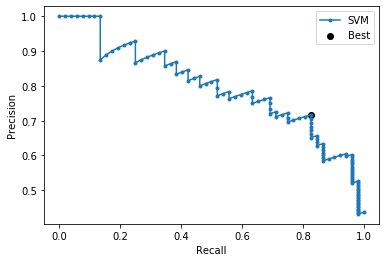

******************* Confusion Matrix ***********************
[[51 17]
 [10 42]]


In [147]:
meniscusThreshold, meniscusFscore, meniscusThresholdPreds = GetBestThreshold(meniscusSVM,X_meniscus_val,y_meniscus_val)

In [118]:
external_train_loader, external_valid_loader = load_data(task='meniscus', plane='axial')
mrnet = MRNet(backbone='alexnet')
model_name = 'model_meniscus_axial_val_auc_0.8156_train_auc_0.9853_epoch_19.pth'
model_path = f'models/alexnet-old/{model_name}'
mrnet.load_state_dict(torch.load(model_path))
_ = mrnet.eval()
mrnet.cuda()
gap = nn.AdaptiveAvgPool2d(1)

meniscus_axial_train_features = []
with torch.no_grad():
    for image, label in tqdm(external_train_loader):
        logit = mrnet.model.features(image.cuda()[0])
        logit = gap(logit).view(logit.size(0), -1)
        logit = torch.max(logit, 0, keepdim=True)[0]
        meniscus_axial_train_features.append(logit[0].cpu().numpy())
        
meniscus_axial_test_features = []
with torch.no_grad():
    for image, label in tqdm(external_valid_loader):
        logit = mrnet.model.features(image.cuda()[0])
        logit = gap(logit).view(logit.size(0), -1)
        logit = torch.max(logit, 0, keepdim=True)[0]
        meniscus_axial_test_features.append(logit[0].cpu().numpy())

In [120]:
paths=[]
img_paths = []
for filename in tqdm(os.listdir('data/fastMRI_axial')):
            if filename.endswith(".npy"):
                img = np.array(np.load('data/fastMRI_axial/'+filename))
                pad = int((img.shape[2] - 224)/2)
                img = img[:,pad:-pad,pad:-pad]
                img = (img-np.min(img))/(np.max(img)-np.min(img))*255
                img = (img - 58.09) / 49.73
                img_paths.append(img)
                img = np.stack((img,)*3, axis=1)
                img_tensor = torch.FloatTensor(img)
                paths.append(img_tensor)

In [121]:
meniscus_axial_external_features=[]
for image in tqdm(paths):
    x = mrnet.model.features(image.cuda())
    x = gap(x).view(x.size(0), -1)
    x = torch.max(x, 0, keepdim=True)[0]
    meniscus_axial_external_features.append(x[0].detach().cpu().numpy())

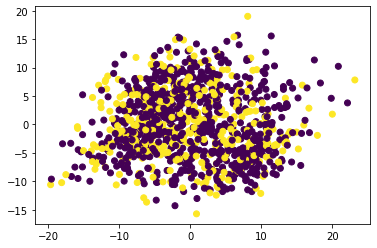

In [127]:
meniscus_axial_train_features_df = pd.DataFrame(meniscus_axial_train_features)
pca = PCA(n_components=2, svd_solver='full')
pca_train = pca.fit_transform(meniscus_axial_train_features_df)
plt.scatter(
    x = pca_train[:,0], 
    y = pca_train[:,1],
    c = y_meniscus
)
plt.show()

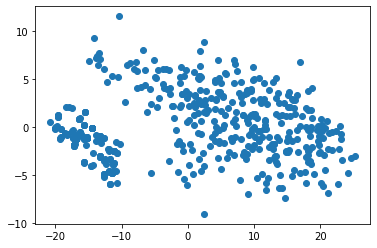

In [129]:
from sklearn.decomposition import PCA

meniscus_axial_external_features_df = pd.DataFrame(meniscus_axial_external_features)
pca = PCA(n_components=2, svd_solver='full')
pca_external = pca.fit_transform(meniscus_axial_external_features_df)
plt.scatter(
    x = pca_external[:,0], 
    y = pca_external[:,1]
)
plt.show()

In [130]:
import sklearn.cluster as cluster
km = cluster.KMeans(n_clusters=2, 
            init='random', 
            n_init=100, max_iter=10000, 
            tol=0.0001, precompute_distances='auto', 
            verbose=0, random_state=None, copy_x=True, 
            n_jobs=None, algorithm='auto'
           )
km.fit(pca_external)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=10000,
       n_clusters=2, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [141]:
pca_train = pca.transform(meniscus_axial_train_features_df)
pred = km.predict(pca_train)
metrics.roc_auc_score(y_abnormal,pred)

0.4994523548740416

In [144]:
meniscus_axial_external_features=[]
for image in tqdm(paths):
    x = mrnet.forward(image.cuda())
    print(torch.sigmoid(x))

tensor([[0.4155]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3097]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4490]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4371]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.6303]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4172]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.8525]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3350]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5128]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4021]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.7124]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3945]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4431]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3375]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3661]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.6729]], device='cuda:0', grad_fn=<SigmoidBac

tensor([[0.3415]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3526]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4308]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3368]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3839]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.7186]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4291]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4158]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.2461]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3711]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3706]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3614]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3428]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4695]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.1017]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4880]], device='cuda:0', grad_fn=<SigmoidBac

tensor([[0.3642]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4289]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4615]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3288]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4166]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.6856]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4771]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4289]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3510]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3519]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.2556]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3943]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.2722]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4799]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.6800]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5498]], device='cuda:0', grad_fn=<SigmoidBac

tensor([[0.3952]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.1959]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3990]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4307]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3739]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4034]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5528]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3773]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5396]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5044]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4157]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4557]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4429]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.0697]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4828]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.3812]], device='cuda:0', grad_fn=<SigmoidBac